# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

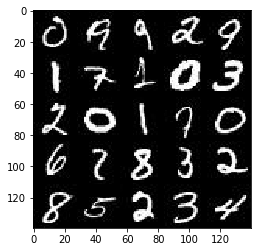

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

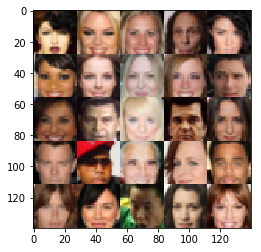

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #(no batch normalization)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 16*16*64 now
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 8x8x128 now
        
        conv3 = tf.layers.conv2d(conv1, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # 4x4x256 now
        
        flat = tf.reshape(conv3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        x = tf.reshape(x, [-1, 4, 4, 512])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 4*4*512 now
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 8*8*256 now
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 16*16*128 now
        #conv2 = conv2[:,1:-1,1:-1,:]
        ## 14*14*128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')
        # 32*32*out_channel_dim now
        logits = logits[:,2:-2,2:-2,:]
        #print(logits.shape)
        # 28*28*out_channel_dim now

        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)

    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        
        _, image_width, image_height, image_channels = real_size
        
        self.input_real, self.input_z, lr = model_inputs(image_width, image_height, image_channels, z_size)
        #lr
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, image_channels, alpha=alpha)
        
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [12]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = pyplot.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        if np.shape(img)[2]==1:  # for 1 channel (grayscale images)
            img = img.squeeze()
            im = ax.imshow(img, aspect='equal', cmap='gray')
        else:
            im = ax.imshow(img, aspect='equal')
        
    pyplot.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every=10
    show_every=100
    figsize=(10,10)
    
    net = GAN(data_shape, z_dim, learning_rate, alpha=0.2, beta1=beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, data_shape[3], is_train=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    if np.shape(gen_samples)[3] == 1:
                        pyplot.imshow(helper.images_square_grid(gen_samples, 'L'), cmap='gray')
                    else:
                        pyplot.imshow(helper.images_square_grid(gen_samples, 'RGB'))
                    pyplot.show()


        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.0928... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 0.8704
Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 1.0039
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.3694
Epoch 1/2... Discriminator Loss: 0.5156... Generator Loss: 1.6691
Epoch 1/2... Discriminator Loss: 0.6506... Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 0.6192... Generator Loss: 2.3327


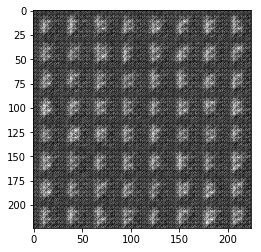

Epoch 1/2... Discriminator Loss: 0.5532... Generator Loss: 1.3157
Epoch 1/2... Discriminator Loss: 0.3980... Generator Loss: 2.7377
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 2.2136
Epoch 1/2... Discriminator Loss: 0.8045... Generator Loss: 1.2740
Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 0.8964
Epoch 1/2... Discriminator Loss: 0.7697... Generator Loss: 1.1196
Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 1.3827
Epoch 1/2... Discriminator Loss: 0.5430... Generator Loss: 1.7086
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.0372
Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 1.0829


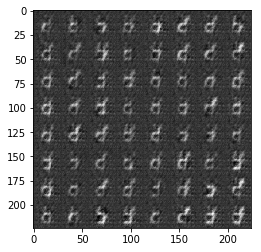

Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.2341
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.2481
Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 1.3045
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 1.2399
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.1633
Epoch 1/2... Discriminator Loss: 0.7309... Generator Loss: 1.2115
Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 1.3654
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.3084


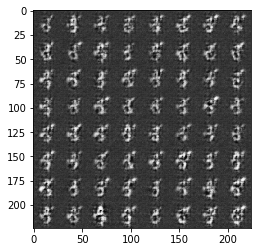

Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 1.4171
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.4532
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.0592
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.2097
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.3886
Epoch 1/2... Discriminator Loss: 0.5744... Generator Loss: 1.4470
Epoch 1/2... Discriminator Loss: 0.6288... Generator Loss: 1.6392
Epoch 1/2... Discriminator Loss: 0.6437... Generator Loss: 1.3385
Epoch 1/2... Discriminator Loss: 0.6342... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 1.4662


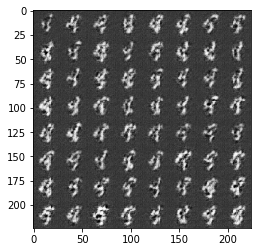

Epoch 1/2... Discriminator Loss: 0.5414... Generator Loss: 1.6880
Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 1.5009
Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 1.6507
Epoch 1/2... Discriminator Loss: 0.5292... Generator Loss: 2.1602
Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 1.6054
Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 1.8605
Epoch 1/2... Discriminator Loss: 0.4593... Generator Loss: 1.6791
Epoch 1/2... Discriminator Loss: 0.5140... Generator Loss: 1.6099
Epoch 1/2... Discriminator Loss: 0.5134... Generator Loss: 1.7240
Epoch 1/2... Discriminator Loss: 0.6199... Generator Loss: 1.8029


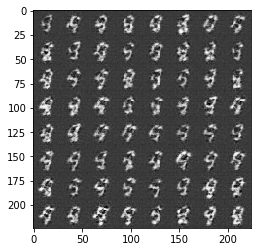

Epoch 1/2... Discriminator Loss: 0.4571... Generator Loss: 1.8082
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 1.7573
Epoch 1/2... Discriminator Loss: 0.3661... Generator Loss: 1.9083
Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 1.7330
Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 2.0043
Epoch 1/2... Discriminator Loss: 0.4709... Generator Loss: 1.9671
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 1.9455
Epoch 1/2... Discriminator Loss: 0.4493... Generator Loss: 2.0959
Epoch 1/2... Discriminator Loss: 0.3656... Generator Loss: 1.7870
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 1.9791


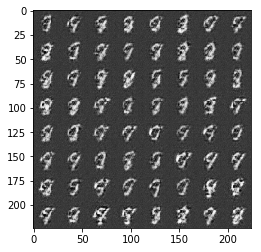

Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 1.8661
Epoch 1/2... Discriminator Loss: 0.3272... Generator Loss: 2.1684
Epoch 1/2... Discriminator Loss: 0.3269... Generator Loss: 2.0773
Epoch 1/2... Discriminator Loss: 0.3902... Generator Loss: 1.7804
Epoch 1/2... Discriminator Loss: 0.3764... Generator Loss: 1.8349
Epoch 1/2... Discriminator Loss: 0.3218... Generator Loss: 2.1373
Epoch 1/2... Discriminator Loss: 0.3166... Generator Loss: 2.1946
Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 2.5298
Epoch 1/2... Discriminator Loss: 0.2791... Generator Loss: 2.2431
Epoch 1/2... Discriminator Loss: 0.2907... Generator Loss: 2.4086


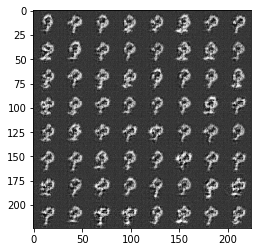

Epoch 1/2... Discriminator Loss: 0.3709... Generator Loss: 2.0198
Epoch 1/2... Discriminator Loss: 0.4214... Generator Loss: 1.9321
Epoch 1/2... Discriminator Loss: 0.3357... Generator Loss: 2.1171
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 1.3947
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 2.1905
Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 2.0576
Epoch 1/2... Discriminator Loss: 0.3946... Generator Loss: 1.6129
Epoch 1/2... Discriminator Loss: 0.7469... Generator Loss: 2.3422
Epoch 1/2... Discriminator Loss: 0.4226... Generator Loss: 1.8854
Epoch 1/2... Discriminator Loss: 0.3009... Generator Loss: 2.1592


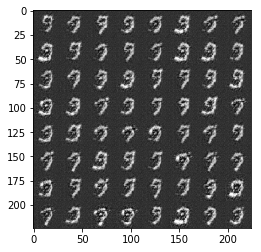

Epoch 1/2... Discriminator Loss: 0.2714... Generator Loss: 2.2324
Epoch 1/2... Discriminator Loss: 0.6583... Generator Loss: 1.9924
Epoch 1/2... Discriminator Loss: 0.3104... Generator Loss: 2.0060
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 1.7595
Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 1.9782
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 1.8687
Epoch 1/2... Discriminator Loss: 0.2760... Generator Loss: 2.2451
Epoch 1/2... Discriminator Loss: 0.2530... Generator Loss: 2.3157
Epoch 1/2... Discriminator Loss: 0.2995... Generator Loss: 2.0998
Epoch 1/2... Discriminator Loss: 0.2509... Generator Loss: 2.3119


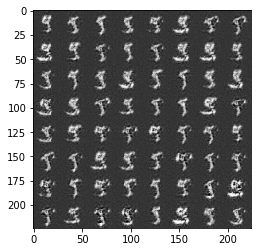

Epoch 1/2... Discriminator Loss: 0.3113... Generator Loss: 2.0244
Epoch 1/2... Discriminator Loss: 0.3220... Generator Loss: 2.3241
Epoch 1/2... Discriminator Loss: 0.2828... Generator Loss: 2.1643
Epoch 2/2... Discriminator Loss: 0.3097... Generator Loss: 2.2843
Epoch 2/2... Discriminator Loss: 0.3439... Generator Loss: 2.2548
Epoch 2/2... Discriminator Loss: 0.2775... Generator Loss: 2.2360
Epoch 2/2... Discriminator Loss: 0.2973... Generator Loss: 2.2322
Epoch 2/2... Discriminator Loss: 0.2717... Generator Loss: 2.3726
Epoch 2/2... Discriminator Loss: 0.2505... Generator Loss: 2.4029
Epoch 2/2... Discriminator Loss: 0.2666... Generator Loss: 2.2980


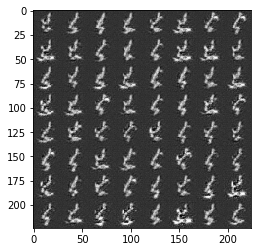

Epoch 2/2... Discriminator Loss: 0.2350... Generator Loss: 2.2824
Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 3.0013
Epoch 2/2... Discriminator Loss: 0.2477... Generator Loss: 2.4056
Epoch 2/2... Discriminator Loss: 0.2954... Generator Loss: 2.5614
Epoch 2/2... Discriminator Loss: 0.2974... Generator Loss: 2.1228
Epoch 2/2... Discriminator Loss: 0.2576... Generator Loss: 2.2854
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 2.8049
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 1.1509
Epoch 2/2... Discriminator Loss: 0.4141... Generator Loss: 2.0830
Epoch 2/2... Discriminator Loss: 0.3937... Generator Loss: 1.9159


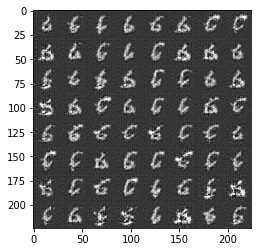

Epoch 2/2... Discriminator Loss: 0.3815... Generator Loss: 1.9150
Epoch 2/2... Discriminator Loss: 0.3657... Generator Loss: 2.1568
Epoch 2/2... Discriminator Loss: 0.7073... Generator Loss: 2.4046
Epoch 2/2... Discriminator Loss: 0.4538... Generator Loss: 2.2673
Epoch 2/2... Discriminator Loss: 0.3224... Generator Loss: 2.2159
Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 1.9450
Epoch 2/2... Discriminator Loss: 0.5627... Generator Loss: 2.1791
Epoch 2/2... Discriminator Loss: 0.3962... Generator Loss: 1.9038
Epoch 2/2... Discriminator Loss: 0.3116... Generator Loss: 2.1149
Epoch 2/2... Discriminator Loss: 0.5824... Generator Loss: 2.0909


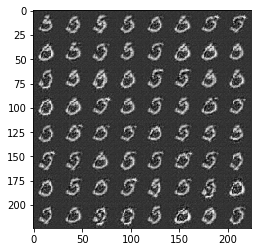

Epoch 2/2... Discriminator Loss: 0.4935... Generator Loss: 1.9871
Epoch 2/2... Discriminator Loss: 0.3474... Generator Loss: 2.1217
Epoch 2/2... Discriminator Loss: 0.3959... Generator Loss: 2.2533
Epoch 2/2... Discriminator Loss: 0.3685... Generator Loss: 2.2586
Epoch 2/2... Discriminator Loss: 0.3347... Generator Loss: 2.1303
Epoch 2/2... Discriminator Loss: 0.4670... Generator Loss: 2.0801
Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 1.8838
Epoch 2/2... Discriminator Loss: 0.3098... Generator Loss: 2.0063
Epoch 2/2... Discriminator Loss: 0.2782... Generator Loss: 2.4422
Epoch 2/2... Discriminator Loss: 0.3116... Generator Loss: 2.0528


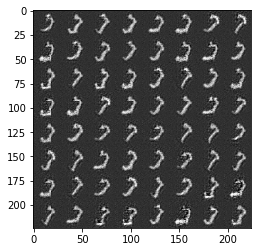

Epoch 2/2... Discriminator Loss: 0.3089... Generator Loss: 2.1000
Epoch 2/2... Discriminator Loss: 0.3091... Generator Loss: 2.1139
Epoch 2/2... Discriminator Loss: 0.3088... Generator Loss: 2.0782
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 2.6044
Epoch 2/2... Discriminator Loss: 0.3250... Generator Loss: 2.0785
Epoch 2/2... Discriminator Loss: 0.3539... Generator Loss: 1.9743
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 2.0992
Epoch 2/2... Discriminator Loss: 0.4213... Generator Loss: 2.0672
Epoch 2/2... Discriminator Loss: 0.3719... Generator Loss: 1.7416
Epoch 2/2... Discriminator Loss: 0.3626... Generator Loss: 2.1017


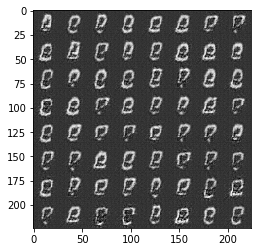

Epoch 2/2... Discriminator Loss: 0.4547... Generator Loss: 2.3720
Epoch 2/2... Discriminator Loss: 0.4176... Generator Loss: 2.0385
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 1.6924
Epoch 2/2... Discriminator Loss: 0.3732... Generator Loss: 2.2680
Epoch 2/2... Discriminator Loss: 0.5770... Generator Loss: 1.8772
Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 2.4260
Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 2.1046
Epoch 2/2... Discriminator Loss: 0.6104... Generator Loss: 1.4735
Epoch 2/2... Discriminator Loss: 0.3838... Generator Loss: 1.8934
Epoch 2/2... Discriminator Loss: 0.4096... Generator Loss: 2.0203


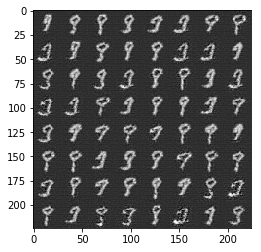

Epoch 2/2... Discriminator Loss: 0.3713... Generator Loss: 1.8137
Epoch 2/2... Discriminator Loss: 0.3983... Generator Loss: 1.8611
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 2.4217
Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 1.9289
Epoch 2/2... Discriminator Loss: 0.4054... Generator Loss: 1.9514
Epoch 2/2... Discriminator Loss: 0.3598... Generator Loss: 2.3160
Epoch 2/2... Discriminator Loss: 0.4764... Generator Loss: 1.5587
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 2.2585
Epoch 2/2... Discriminator Loss: 0.3415... Generator Loss: 2.0953
Epoch 2/2... Discriminator Loss: 0.3500... Generator Loss: 1.9194


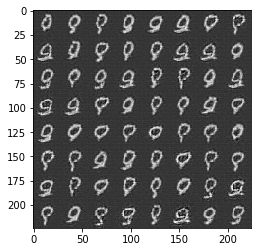

Epoch 2/2... Discriminator Loss: 0.3668... Generator Loss: 1.7817
Epoch 2/2... Discriminator Loss: 0.4164... Generator Loss: 2.3436
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 2.1672
Epoch 2/2... Discriminator Loss: 0.4187... Generator Loss: 2.0350
Epoch 2/2... Discriminator Loss: 0.3323... Generator Loss: 1.9064
Epoch 2/2... Discriminator Loss: 0.3040... Generator Loss: 2.2616
Epoch 2/2... Discriminator Loss: 0.4254... Generator Loss: 2.0692
Epoch 2/2... Discriminator Loss: 0.3624... Generator Loss: 1.8208
Epoch 2/2... Discriminator Loss: 0.3374... Generator Loss: 2.0701
Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 2.0329


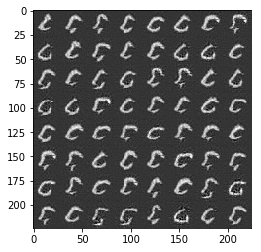

Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 2.1173
Epoch 2/2... Discriminator Loss: 0.3105... Generator Loss: 1.9985
Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 2.2149
Epoch 2/2... Discriminator Loss: 0.2878... Generator Loss: 2.0216
Epoch 2/2... Discriminator Loss: 0.2874... Generator Loss: 2.3107
Epoch 2/2... Discriminator Loss: 0.3086... Generator Loss: 2.2627
Epoch 2/2... Discriminator Loss: 0.3819... Generator Loss: 1.8869
Epoch 2/2... Discriminator Loss: 0.6728... Generator Loss: 1.5202
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 2.0001
Epoch 2/2... Discriminator Loss: 0.3521... Generator Loss: 2.3442


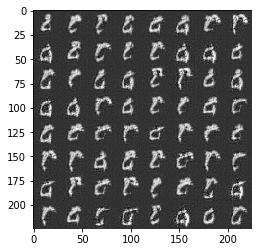

Epoch 2/2... Discriminator Loss: 0.3362... Generator Loss: 2.0276
Epoch 2/2... Discriminator Loss: 0.4104... Generator Loss: 2.1042
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 2.0237
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 2.1431
Epoch 2/2... Discriminator Loss: 0.3938... Generator Loss: 1.9449
Epoch 2/2... Discriminator Loss: 0.3251... Generator Loss: 2.0248
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.8577


In [ ]:
tf.reset_default_graph()

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.3107
Epoch 1/1... Discriminator Loss: 0.5962... Generator Loss: 1.8391
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.0049
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 2.2811
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 2.1563
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.3412
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 1.4515


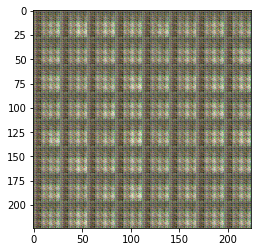

Epoch 1/1... Discriminator Loss: 0.3238... Generator Loss: 2.0074
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 2.5170
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 3.3352
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 2.0068
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 1.8512
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 2.3784
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 2.1172
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 1.6138
Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 1.4123


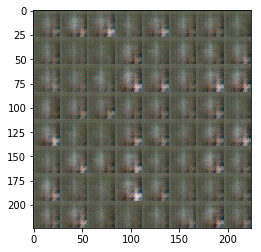

Epoch 1/1... Discriminator Loss: 0.3143... Generator Loss: 2.4843
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 1.5151
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 2.0990
Epoch 1/1... Discriminator Loss: 0.3204... Generator Loss: 2.2741
Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 1.7453
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 3.4844
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 1.7191
Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 2.1133
Epoch 1/1... Discriminator Loss: 0.2600... Generator Loss: 3.1345
Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 2.7135


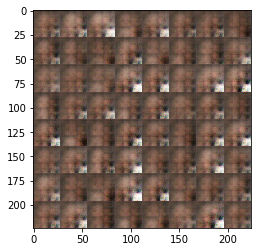

Epoch 1/1... Discriminator Loss: 0.3105... Generator Loss: 2.2438
Epoch 1/1... Discriminator Loss: 0.2948... Generator Loss: 2.5971
Epoch 1/1... Discriminator Loss: 0.3007... Generator Loss: 3.3137
Epoch 1/1... Discriminator Loss: 0.3035... Generator Loss: 2.5835
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 1.6933
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 2.1488
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 1.6909
Epoch 1/1... Discriminator Loss: 0.3060... Generator Loss: 2.7706
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 2.7140
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 1.2292


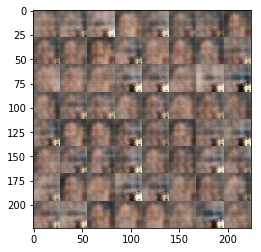

Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 1.9813
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.2290
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 1.7798
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 2.3801
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 2.0478
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 1.5337
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 2.9437
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.0352


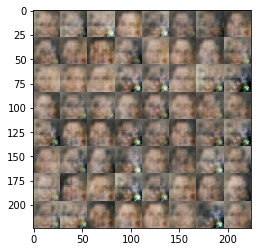

Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 4.5246
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 1.8135
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 1.4948
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 1.7839
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 1.7226
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 3.3623
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.9880
Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 2.0313


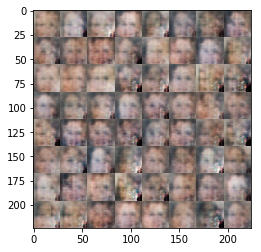

Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.7017
Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 2.3423
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.4112
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 2.2184
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 1.8417


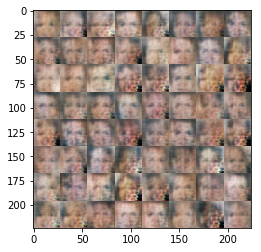

Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 1.4484
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 1.6882
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 1.9644
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 2.3046
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 1.5232
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.1669
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.2614


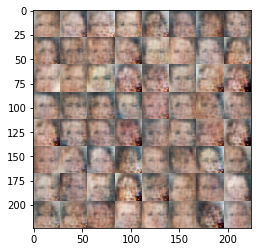

Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 2.3733
Epoch 1/1... Discriminator Loss: 0.3334... Generator Loss: 3.1128
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.9856
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 1.7109
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 1.4874
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.1838


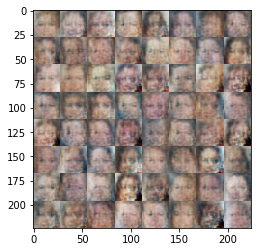

Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 4.7828
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.4494
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.5660
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 5.7799
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.8744
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.3882
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.7553


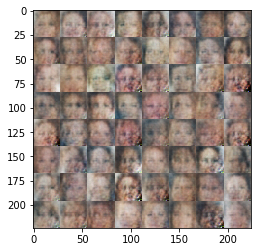

Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.5097
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.3961
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.6456
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.3979
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 2.6617


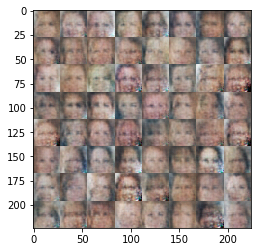

Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.6058
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 2.5247
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.4504


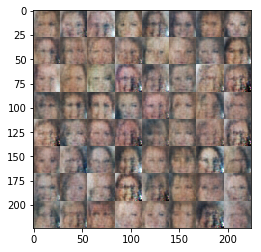

Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 2.1608
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.5106
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.1670


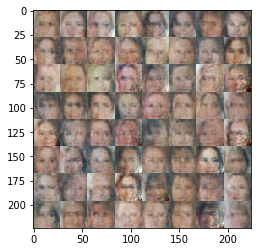

Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 2.0638
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9259


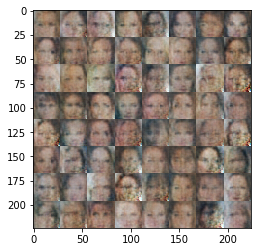

Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.2931
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 2.7306
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.7080
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.8432
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.4424
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.3792


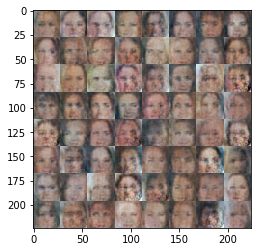

Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.3076


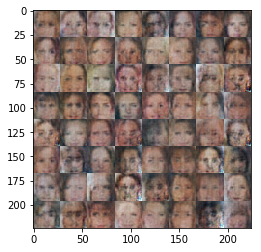

Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.7580
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.6022
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.7980
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.6409
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.1428


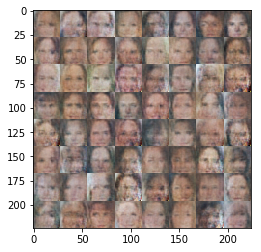

Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 2.4674
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 2.4929
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.1465


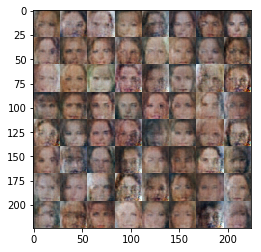

Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1547


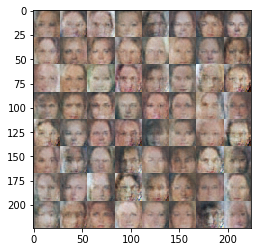

Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.8648
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.4008
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.8227
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.9129


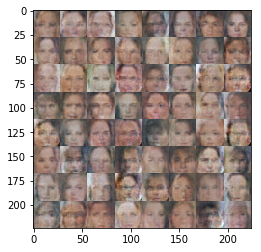

Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.9027
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 2.4454
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.8931


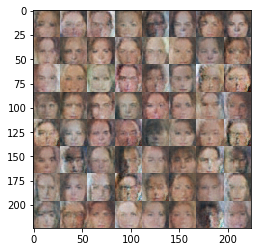

Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.0455


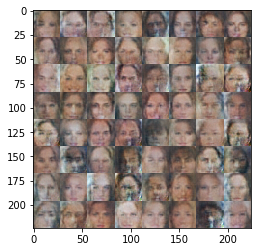

Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.6077
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.0274


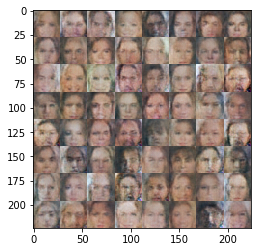

Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.9230


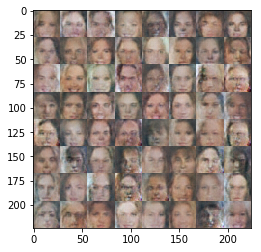

Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.8987
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.5176
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.3538
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.5994


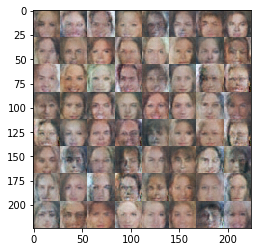

Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.8973


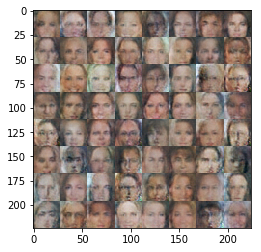

Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.3443


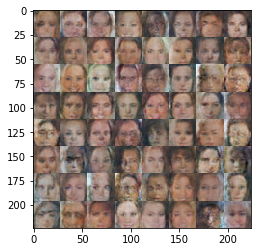

Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.8158


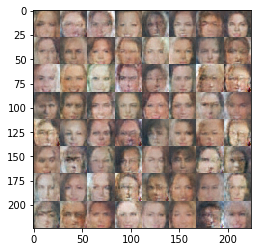

Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.7150
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.7768


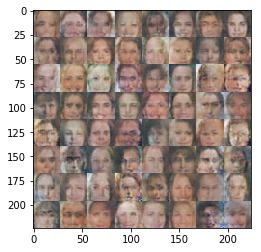

Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.2452
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.7003


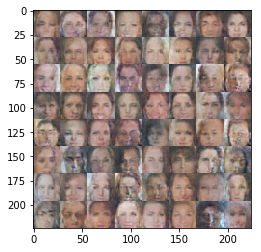

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.2024


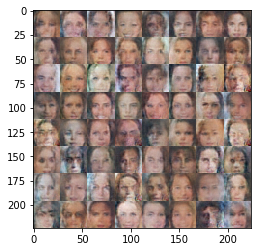

Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9102


In [ ]:
tf.reset_default_graph()

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.